In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import shap
import rasterio
from rasterio.plot import show

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


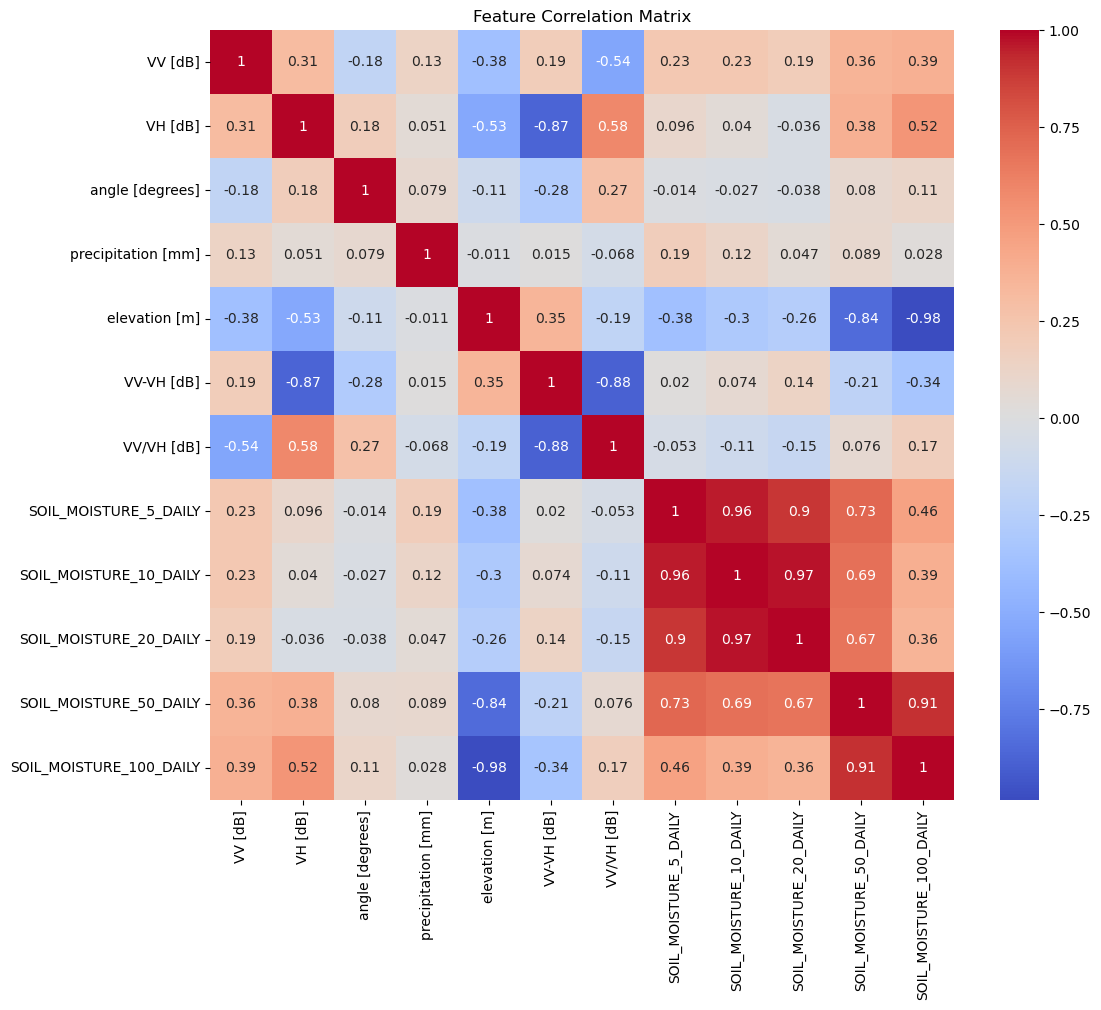

In [ ]:
# Load and preprocess data
df = pd.read_csv("Datasets/ML_Training_Selected.csv")

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [3]:
# Calculate SOIL_MOISTURE_15_DAILY and SOIL_MOISTURE_75_DAILY
df['SOIL_MOISTURE_15_DAILY'] = (df['SOIL_MOISTURE_10_DAILY'] + df['SOIL_MOISTURE_20_DAILY']) / 2
df['SOIL_MOISTURE_75_DAILY'] = (df['SOIL_MOISTURE_50_DAILY'] + df['SOIL_MOISTURE_100_DAILY']) / 2

# Drop unnecessary columns
df.drop(columns=['SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY', 'SOIL_MOISTURE_100_DAILY'], inplace=True)

# Clean column names
df.columns = df.columns.str.replace('[\[\]<>]', '', regex=True).str.replace(' ', '_')

# Define features
features = ['VV_dB', 'VH_dB', 'angle_degrees', 'precipitation_mm', 'elevation_m', 'VV-VH_dB', 'VV/VH_dB']

# Normalize elevation
scaler = StandardScaler()
df['elevation_m'] = scaler.fit_transform(df[['elevation_m']])

# Target variables
targets = {
    'SOIL_MOISTURE_5_DAILY': None,
    'SOIL_MOISTURE_15_DAILY': None,
    'SOIL_MOISTURE_75_DAILY': None
}

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:26<00:00,  3.76trial/s, best loss: 0.07512127138529193]
--- SOIL_MOISTURE_5_DAILY ---
Train R^2: 0.456, RMSE: 0.060
Test R^2: 0.012, RMSE: 0.072


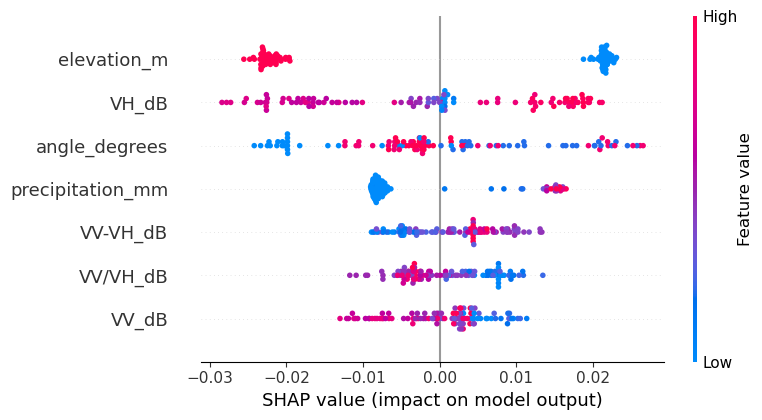

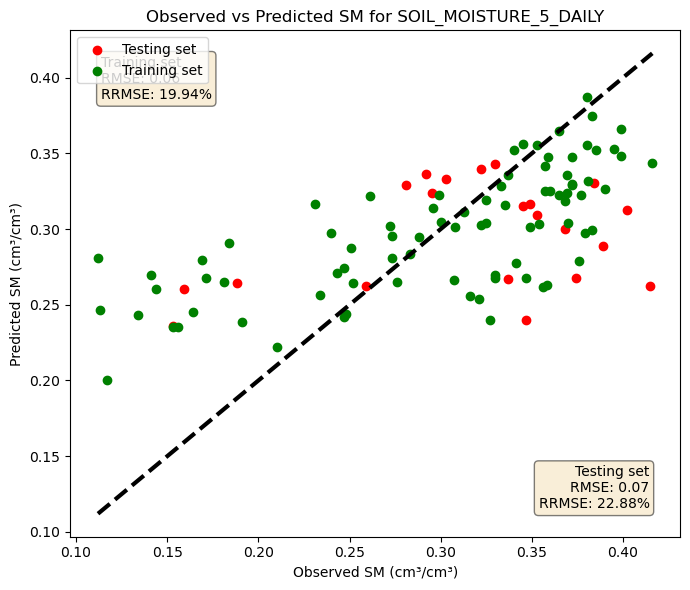

100%|██████████| 100/100 [00:27<00:00,  3.63trial/s, best loss: 0.06069632604278911]
--- SOIL_MOISTURE_15_DAILY ---
Train R^2: 0.482, RMSE: 0.046
Test R^2: -0.019, RMSE: 0.062


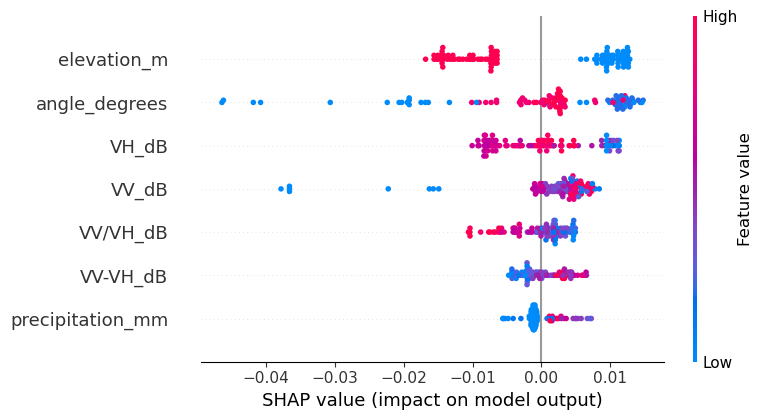

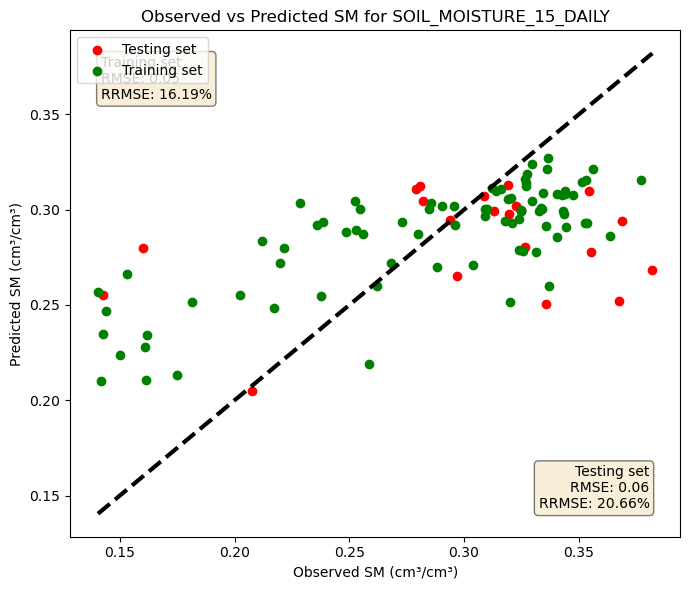

100%|██████████| 100/100 [00:29<00:00,  3.37trial/s, best loss: 0.034898142878823826]
--- SOIL_MOISTURE_75_DAILY ---
Train R^2: 0.999, RMSE: 0.004
Test R^2: 0.831, RMSE: 0.044


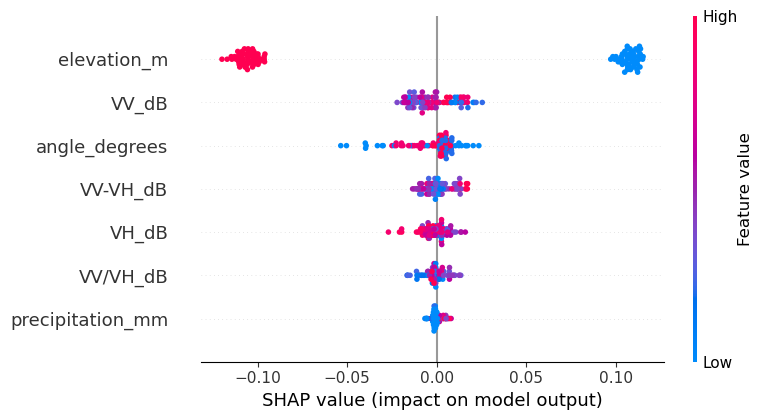

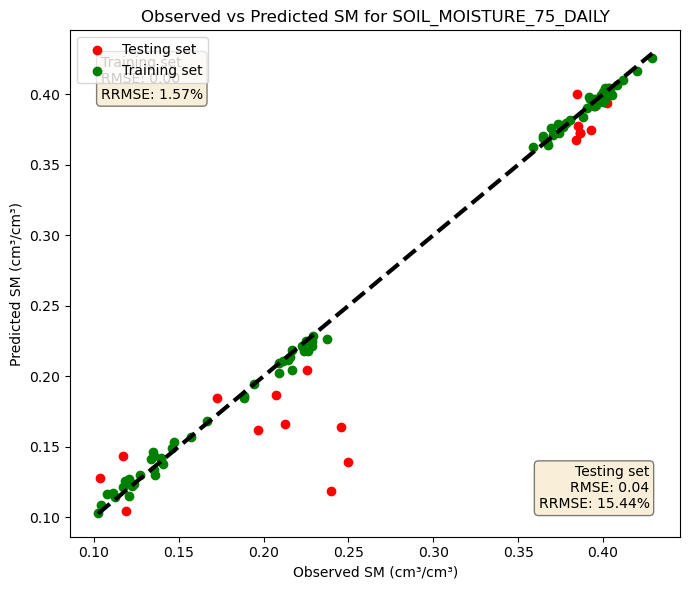

In [4]:
# Dictionary to store trained models
targets = {}

# Define hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 8)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(3, 6)),
    'max_depth': hp.choice('max_depth', range(2, 4)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.05, 0.5),
    'random_state': 42,
}

random_seed = 42
X = df[features]

# Tune, train, and evaluate each model separately
for target_col in ['SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_15_DAILY', 'SOIL_MOISTURE_75_DAILY']:
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    def objective(params):
        model = GradientBoostingRegressor(**params)
        kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        rmse_list = []
        for train_idx, test_idx in kf.split(X_train):
            model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            preds = model.predict(X_train.iloc[test_idx])
            rmse = np.sqrt(mean_squared_error(y_train.iloc[test_idx], preds))
            rmse_list.append(rmse)
        return {'loss': np.mean(rmse_list), 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(random_seed))

    best_params = {
        'n_estimators': range(50, 300)[best['n_estimators']],
        'min_samples_split': range(2, 8)[best['min_samples_split']],
        'min_samples_leaf': range(3, 6)[best['min_samples_leaf']],
        'max_depth': range(2, 4)[best['max_depth']],
        'learning_rate': best['learning_rate'],
        'subsample': best['subsample'],
        'random_state': 42
    }

    final_model = GradientBoostingRegressor(**best_params)
    final_model.fit(X_train, y_train)
    y_pred_train = final_model.predict(X_train)
    y_pred_test = final_model.predict(X_test)
    print(f"--- {target_col} ---")
    print(f"Train R^2: {r2_score(y_train, y_pred_train):.3f}, RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")
    print(f"Test R^2: {r2_score(y_test, y_pred_test):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.3f}")

    explainer = shap.Explainer(final_model)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, feature_names=X.columns)

        # Create observed vs predicted scatter plot with RMSE and RRMSE only
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_test, y_pred_test, color='red', label='Testing set')
    ax.scatter(y_train, y_pred_train, color='green', label='Training set')
    ax.plot([min(y.min(), y_pred_test.min()), max(y.max(), y_pred_test.max())],
            [min(y.min(), y_pred_test.min()), max(y.max(), y_pred_test.max())],
            'k--', lw=3)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rrmse_train = rmse_train / np.mean(y_train) * 100
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rrmse_test = rmse_test / np.mean(y_test) * 100

    textstr_train = f"Training set\nRMSE: {rmse_train:.2f}\nRRMSE: {rrmse_train:.2f}%"
    textstr_test = f"Testing set\nRMSE: {rmse_test:.2f}\nRRMSE: {rrmse_test:.2f}%"

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr_train, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    ax.text(0.95, 0.05, textstr_test, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', ha='right', bbox=props)

    ax.set_xlabel('Observed SM (cm³/cm³)')
    ax.set_ylabel('Predicted SM (cm³/cm³)')
    ax.set_title(f"Observed vs Predicted SM for {target_col}")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"Observed_vs_Predicted_{target_col}.png", dpi=300)
    plt.show()

    targets[target_col] = final_model

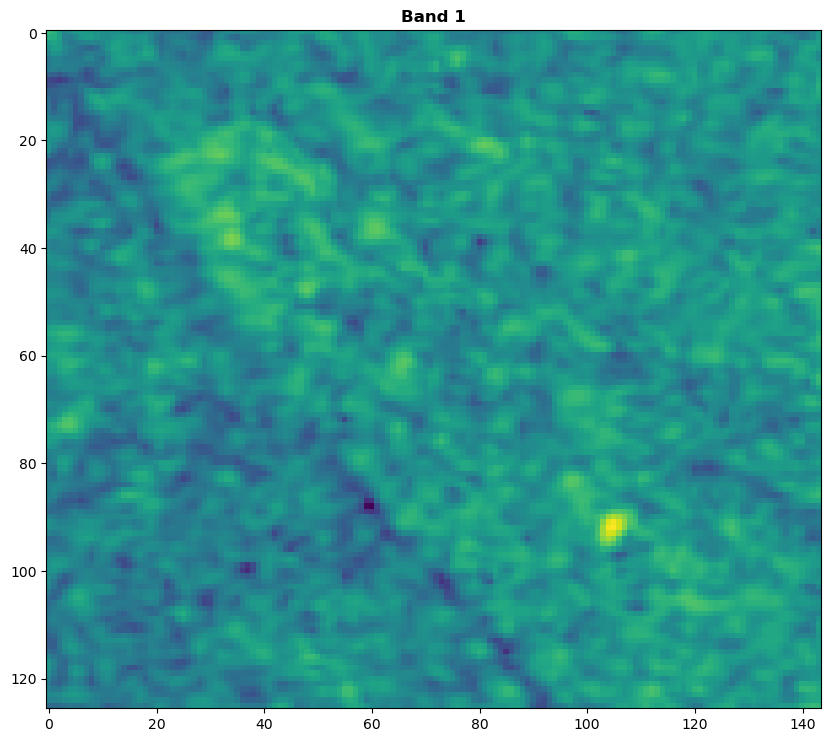

Band names: ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5']


In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Open the TIFF file
file_path = 'Datasets/FrankFort_Lexington_MultiBand_2024.tif'
with rasterio.open(file_path) as dataset:
    # Display the first band of the TIFF file
    plt.figure(figsize=(10, 10))
    show(dataset.read(1), title="Band 1")
    plt.show()
    
    # Print the band names
    band_names = [f"Band {i}" for i in range(1, dataset.count + 1)]
    print("Band names:", band_names)

In [ ]:
import rasterio
import numpy as np
from rasterio.transform import from_origin

# Open the input TIFF file
with rasterio.open(file_path) as dataset:
    # Read all bands into a numpy array
    raster_data = dataset.read()

# Calculate VV-VH and VV/VH bands
vv_vh_band = raster_data[0] - raster_data[1]  # VV-VH
vv_div_vh_band = raster_data[0] / raster_data[1]  # VV/VH

# Stack the bands in the specified order
new_bands = [
    raster_data[0],  # VV [dB]
    raster_data[1],  # VH [dB]
    raster_data[2],  # angle [degrees]
    raster_data[3],  # precipitation [mm]
    raster_data[4],  # elevation [m]
    vv_vh_band,      # VV-VH [dB]
    vv_div_vh_band   # VV/VH [dB]
]
new_bands = np.stack(new_bands)

# Define metadata for the new TIFF
new_meta = dataset.meta.copy()
new_meta.update({
    "count": len(new_bands),  # Number of bands
    "dtype": new_bands.dtype  # Data type of the bands
})

# Write the new TIFF file
output_file = "Datasets/Updated_Frankfor_Lexington.tif"
with rasterio.open(output_file, "w", **new_meta) as dst:
    for i in range(len(new_bands)):
        dst.write(new_bands[i], i + 1)  # Write each band to the file

print(f"New TIFF file created: {output_file}")

New TIFF file created: Updated_Frankfor_Lexington.tif


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


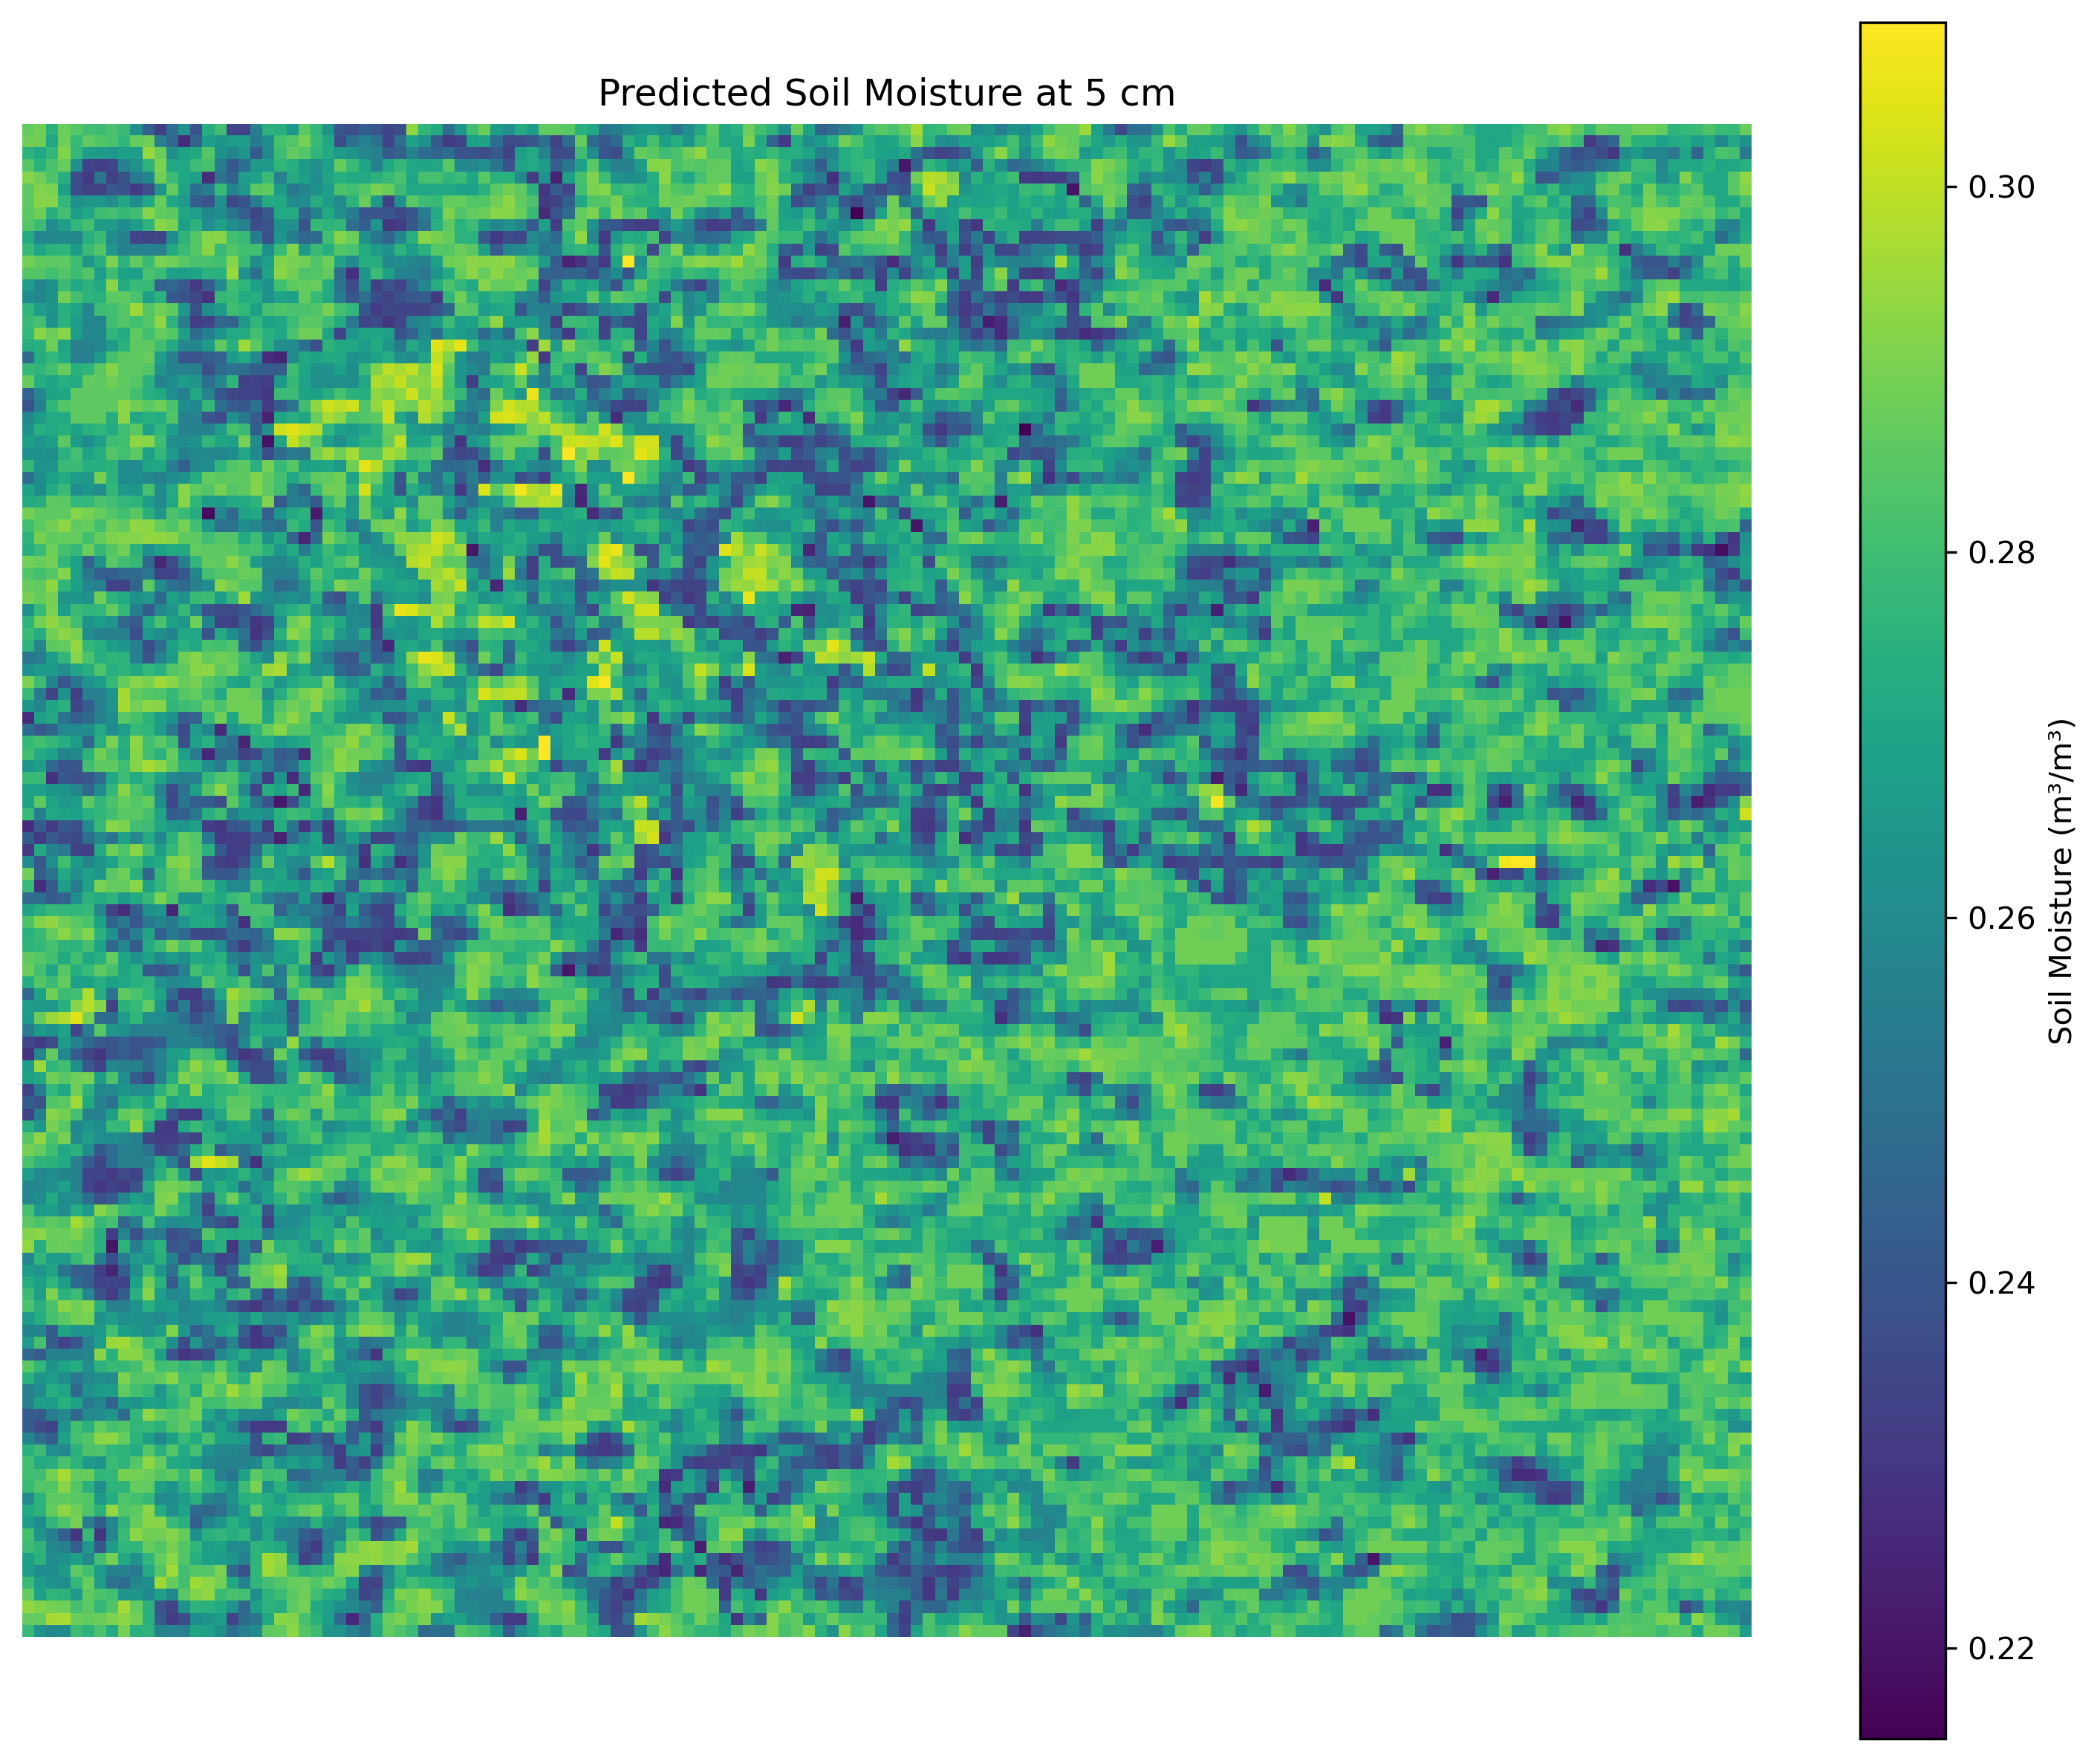

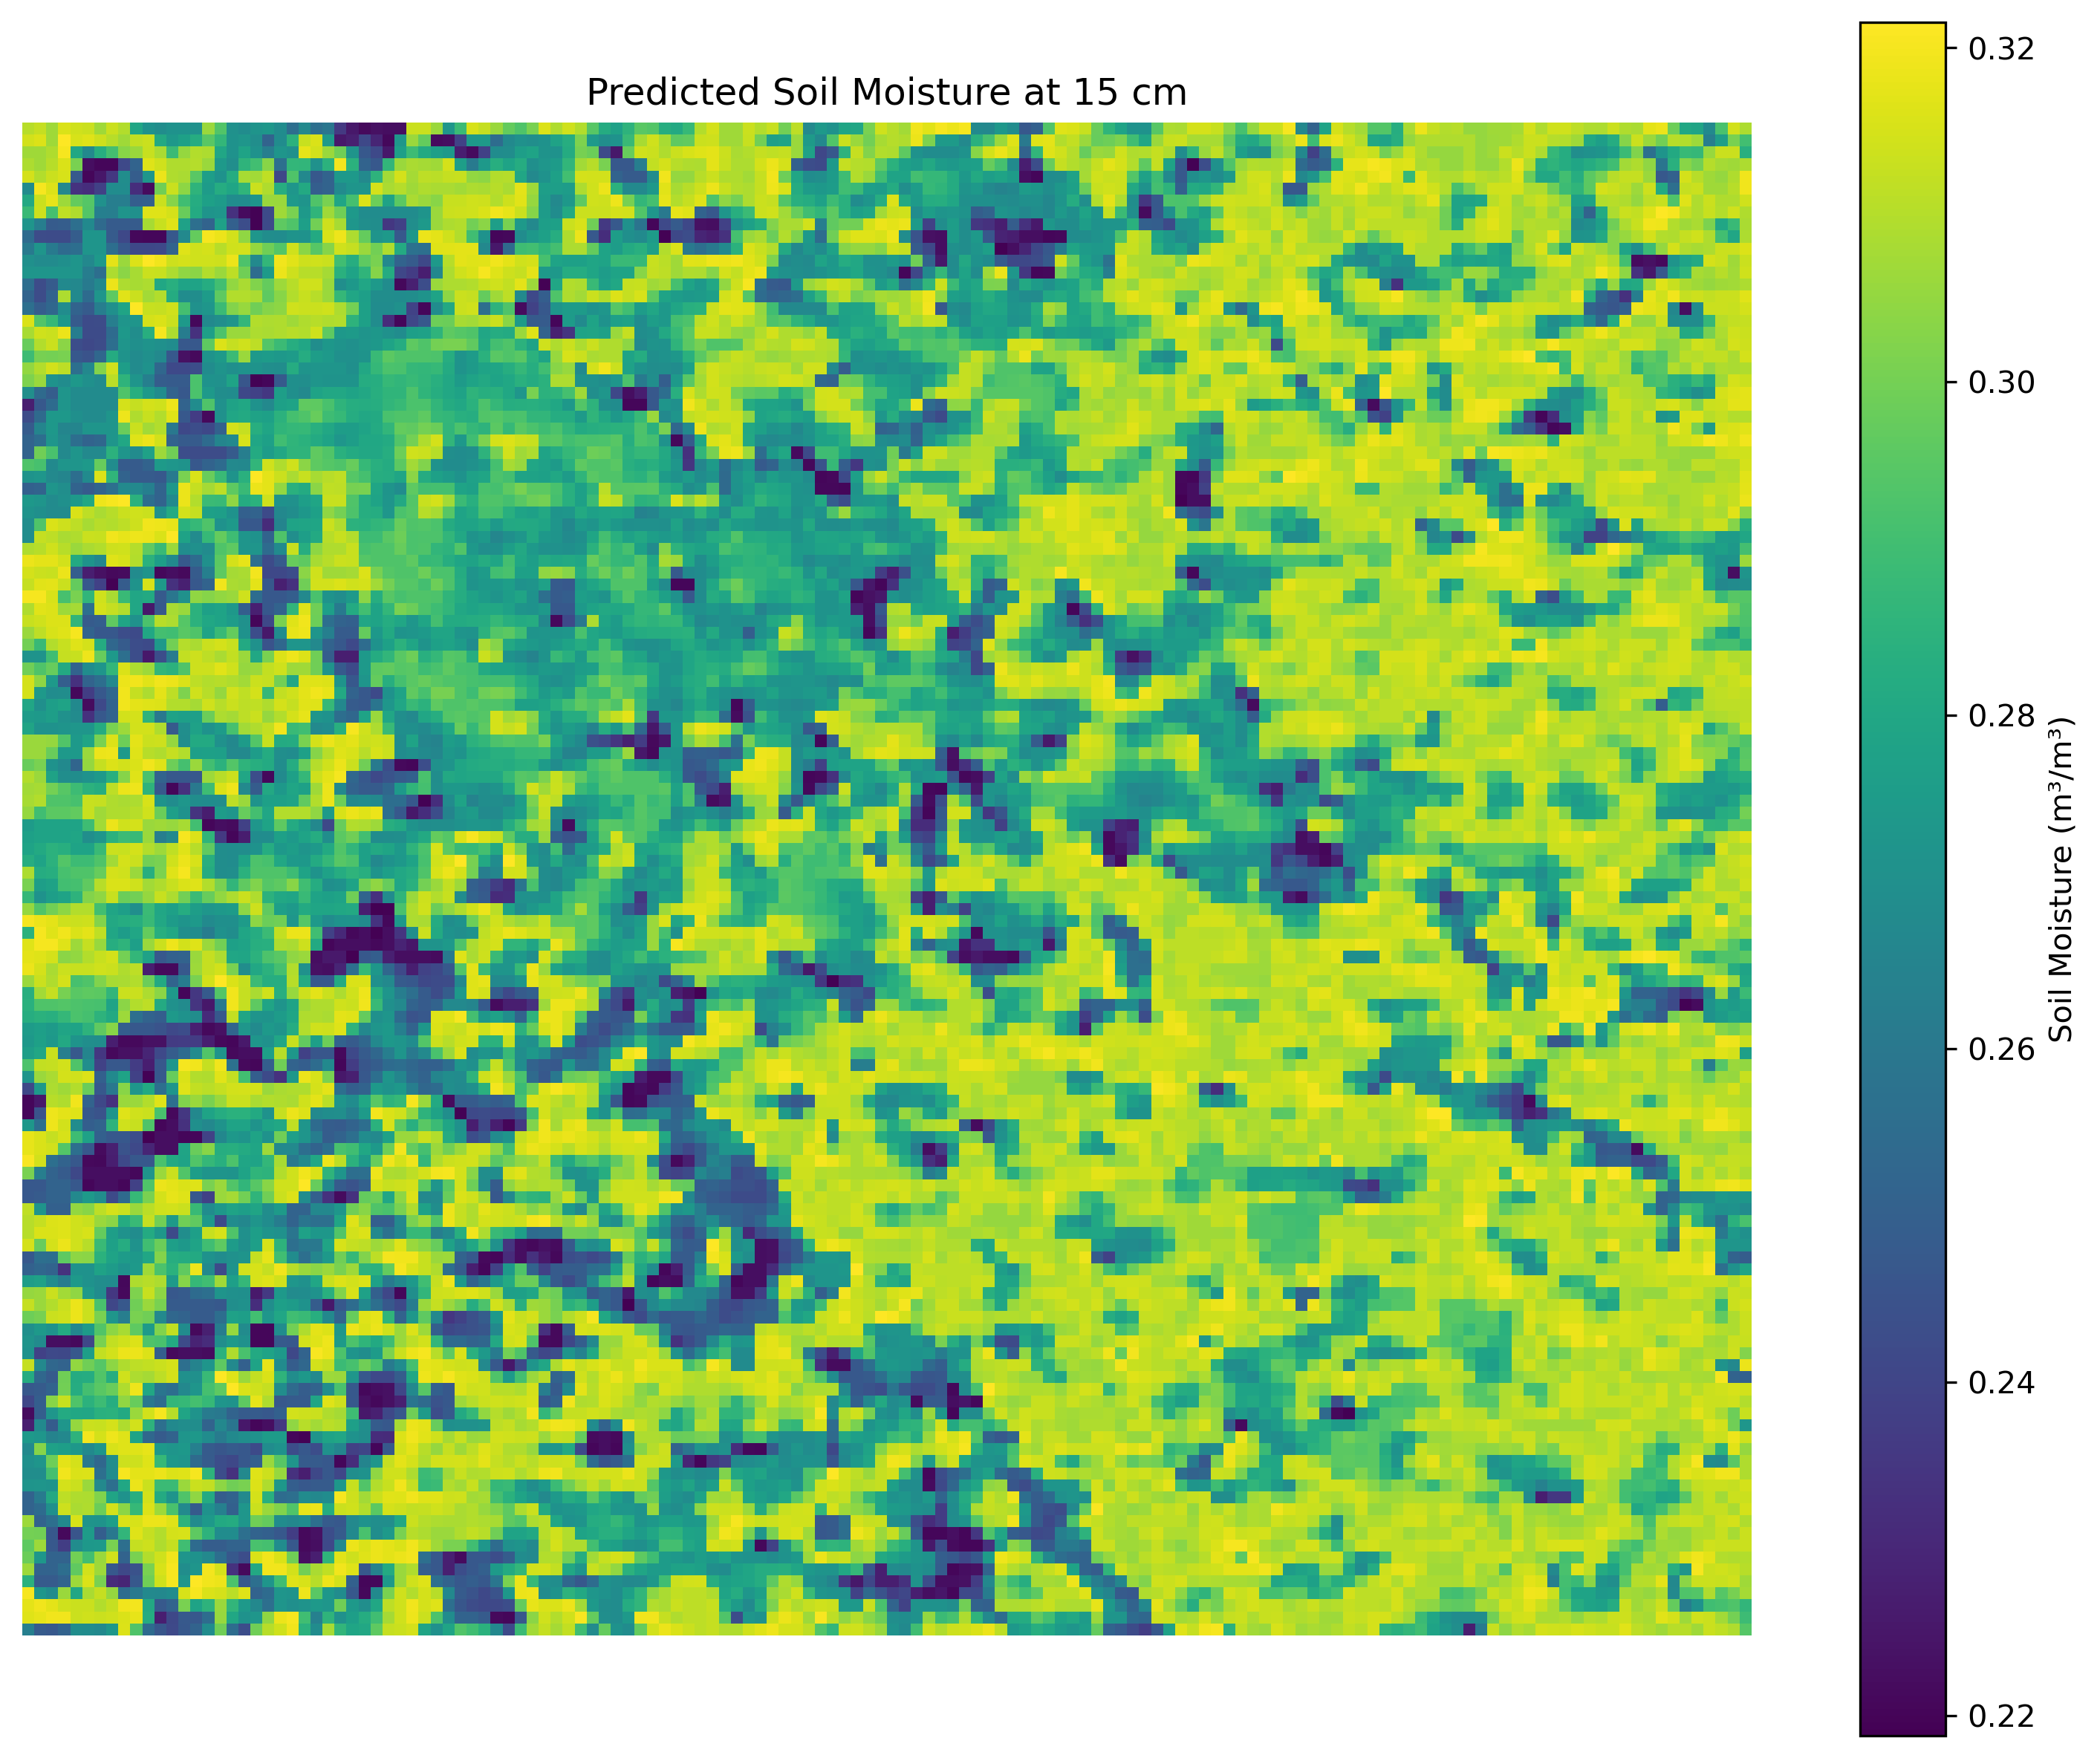

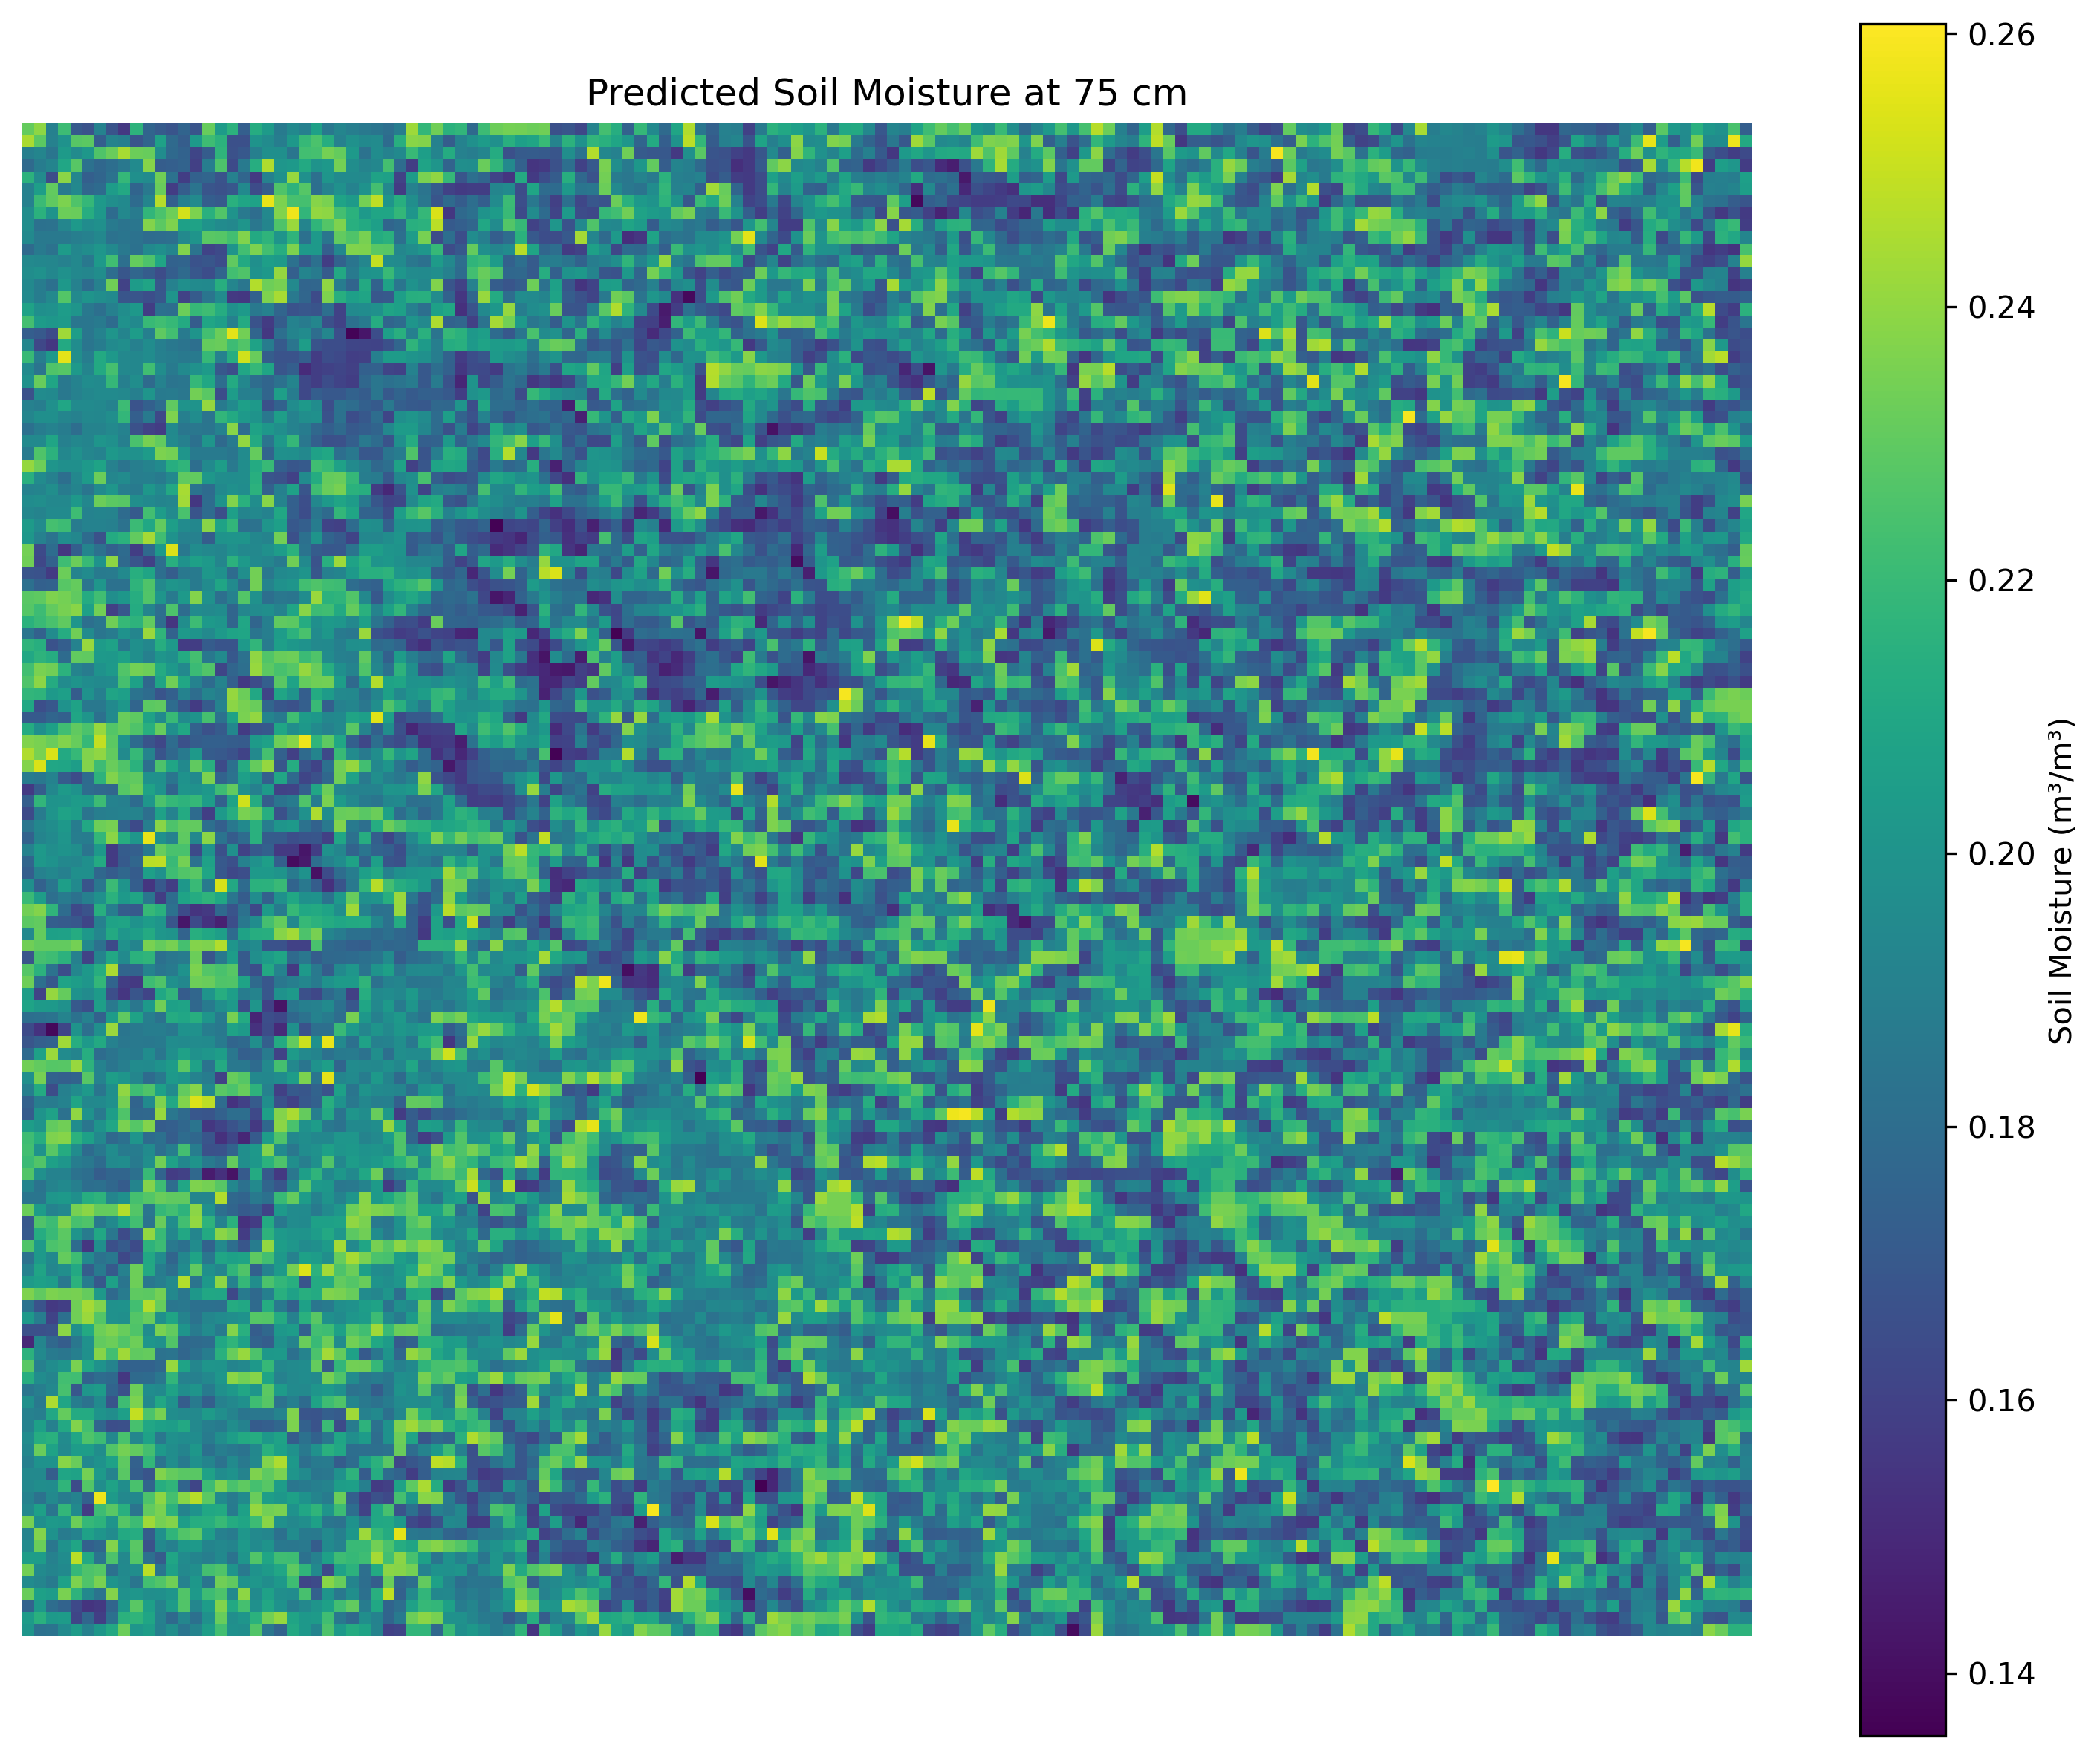

In [ ]:
# Predict on TIFF raster pixel-wise and log RMSE in CSV
file_path = "Datasets/Updated_Frankfor_Lexington.tif"
with rasterio.open(file_path) as src:
    bands = src.read()
    bands = np.transpose(bands, (1, 2, 0))
    rows, cols, num_bands = bands.shape
    reshaped_data = bands.reshape(-1, num_bands)

    predicted_sm = np.zeros((reshaped_data.shape[0], 3))
    for i, (target, model) in enumerate(targets.items()):
        predicted_sm[:, i] = model.predict(reshaped_data)

    predicted_sm = predicted_sm.reshape(rows, cols, 3)
    depths = ['5 cm', '15 cm', '75 cm']

    for i in range(3):
        plt.figure(figsize=(10, 8), dpi=300)
        plt.imshow(predicted_sm[:, :, i], cmap='viridis')
        plt.colorbar(label='Soil Moisture (m³/m³)')
        plt.title(f"Predicted Soil Moisture at {depths[i]}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"Predicted_Soil_Moisture_{depths[i].replace(' ', '_')}.png", dpi=300)
        with rasterio.open(
            f"Predicted_Soil_Moisture_{depths[i].replace(' ', '_')}.tif",
            "w",
            driver="GTiff",
            height=rows,
            width=cols,
            count=1,
            dtype=predicted_sm.dtype,
            crs=src.crs,
            transform=src.transform,
        ) as dst:
            dst.write(predicted_sm[:, :, i], 1)
        plt.show()


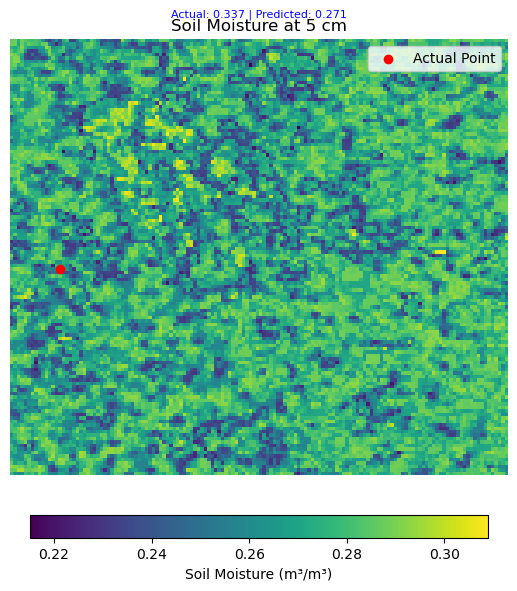

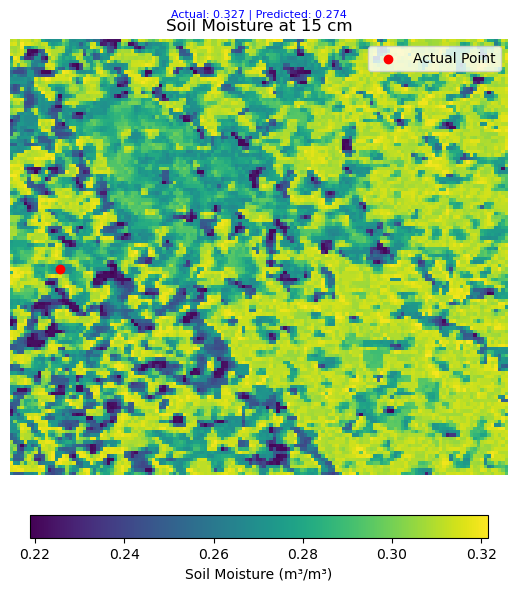

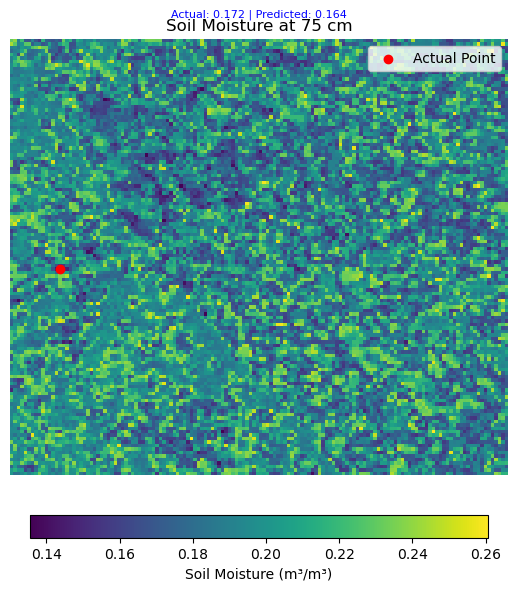

Saved RMSE comparison to insitu_comparison_rmse.csv


In [ ]:
# Compare with in-situ data and log metrics
insitu_data = pd.read_csv("Datasets/cleaned_Insitu_SM_2024_ILINKS.csv")
insitu_data['SOIL_MOISTURE_15_DAILY'] = (insitu_data['SOIL_MOISTURE_10_DAILY'] + insitu_data['SOIL_MOISTURE_20_DAILY']) / 2
insitu_data['SOIL_MOISTURE_75_DAILY'] = (insitu_data['SOIL_MOISTURE_50_DAILY'] + insitu_data['SOIL_MOISTURE_100_DAILY']) / 2

latitude = 38.09
longitude = -84.75
date = 20240101
point = insitu_data[(insitu_data['LATITUDE'] == latitude) &
                    (insitu_data['LONGITUDE'] == longitude) &
                    (insitu_data['LST_DATE'] == date)]
actual_values = point[['SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_15_DAILY', 'SOIL_MOISTURE_75_DAILY']].values.flatten()

lat_idx = int((latitude - src.bounds.top) / src.res[1])
lon_idx = int((src.bounds.left - longitude) / src.res[0])
predicted_values = predicted_sm[lat_idx, lon_idx, :3]

# Initialize rmse_log as an empty list
rmse_log = []

for i in range(3):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(predicted_sm[:, :, i], cmap='viridis')
    ax.set_title(f"Soil Moisture at {depths[i]}")
    ax.axis('off')
    ax.scatter(lon_idx, lat_idx, color='red', label='Actual Point')
    ax.legend()
    rmse = np.sqrt(mean_squared_error([actual_values[i]], [predicted_values[i]]))
    rmse_log.append({'Depth': depths[i], 'Actual': actual_values[i], 'Predicted': predicted_values[i], 'RMSE': rmse})
    ax.text(0.5, 1.05, f"Actual: {actual_values[i]:.3f} | Predicted: {predicted_values[i]:.3f}",
        transform=ax.transAxes, fontsize=8, ha='center', color='blue')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
    cbar.set_label('Soil Moisture (m³/m³)')
    plt.tight_layout()
    plt.savefig(f"InSitu_Comparison_{depths[i].replace(' ', '_')}.png", dpi=300)
    plt.show()

# Save RMSE log to CSV
rmse_df = pd.DataFrame(rmse_log)
rmse_df.to_csv("insitu_comparison_rmse.csv", index=False)
print("Saved RMSE comparison to insitu_comparison_rmse.csv")
                